# Prepare notebook and load preprocessed tweets
Tweets have been preprocessed as follows:
* Remove a range of non-word characters
* Remove URLS
* Remove usernames
* Remove hashtags
* Tokenized and lemmatized (Stanza)
* Removed stopwords (NLTK)
* Only kept part-of-speech equalt to 'NOUN', 'PROPN' (proper noun) and 'VERB'
* Lowercase and remove digits as well as words less than 4 characters long

In [1]:
### Set path to directories
from pathlib import Path
_nb = Path(Path.cwd()) # Path of the notebook
_data = _nb.parent / 'Data' / '1. NGO' / 'Processed tweets' # Path to the preprocessed tweets

In [2]:
### Load preprocessed tweets
import pickle
import pandas as pd

fname = '2020-08-31_dk.pkl' # Name of file
with open(_data / fname, 'rb') as handle:
    df = pickle.load(handle)
len(df)

874

In [3]:
### Example of tweets

# Original tweet
print(df.iloc[2].text)
print('------')

# Preprocessed tweet
print(df.iloc[2].proc_text)
print('------')

# NGO
print(df.iloc[2].screen_name)


Vi har skaffet os adgang til hemmelige optagelser af regeringens møder med erhvervslivet - herunder klimapartnerskaberne. Se med! #dkpol #dkgreen https://t.co/80XJoMPN4M
------
skaffe adgang optagelse regering møde erhvervsliv klimapartnerskab
------
Klimabev


# Identify local word associations

In [4]:
### Identify whether each word appear in each tweet or not
# The column proc_text holds the preprocessed tweet
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
vectorizer = CountVectorizer(ngram_range=(1,1)) # Instantiante the counting class
doc2type = vectorizer.fit_transform(df.proc_text) # Count the number of times each word type appear in each tweet
doc2type[doc2type>0] = 1 # Restrict count to 1, i.e. we get the tweet-frequency of each word (how many tweets it appear in) 
type_names = np.array(vectorizer.get_feature_names()) # Get the sequence of words according to how they are counted
n_docs, n_types = doc2type.shape

In [5]:
# Example of counting
print(df.proc_text[2])
for word in df.proc_text[2].split(' ')+['olie']:
    print('{}: {}'.format(word, doc2type[2, vectorizer.vocabulary_[word]]))

skaffe adgang optagelse regering møde erhvervsliv klimapartnerskab
skaffe: 1
adgang: 1
optagelse: 1
regering: 1
møde: 1
erhvervsliv: 1
klimapartnerskab: 1
olie: 0


In [6]:
### Identify (in)frequent words

# Determine absolute threshold
abs_th = 5

# Calculate the tweet-frequency of each word
type_doc_freq = np.squeeze(np.asarray(np.sum(doc2type, axis=0)/n_docs))

# Identify indices of words that meet the threshold - returns boolean (True/False) array of length = number of words 
type_mask = type_doc_freq >= abs_th/n_docs

# Identify the indices of words that meet the threshold
type_mask_idx = np.arange(n_types)[type_mask]

# Print number and share of words that meet criteria
print('{} words ({:0.0f}%) appear in at least {} tweets'.format(sum(type_mask), 100*sum(type_mask)/n_types, abs_th))

366 words (13%) appear in at least 5 tweets


In [7]:
### Calculate association between words
import scipy.sparse as sp

# Calculate the binarized type co-occurence matrix
type_cooc = doc2type.T @ doc2type

# Calculate the co-occurence tweet-frequency
cooc_doc_freq = type_cooc / n_docs # Does not sum to one, as one terms occurence in a tweet does not exclude others

# Divide observed co-occurence frequency with product of marginal word frequencies (expected co-occurence if 'independent')
# and scale with actual frequency, to give less weight to infrequent co-occurences
type_cooc_assoc = cooc_doc_freq.multiply(sp.csr_matrix(cooc_doc_freq / (sp.csr_matrix(type_doc_freq).T @ sp.csr_matrix(type_doc_freq)))) 

# Drop self-association
type_cooc_assoc = type_cooc_assoc - sp.dia_matrix((type_cooc_assoc.diagonal()[np.newaxis, :], [0]), shape=type_cooc_assoc.shape)

In [8]:
### Restrict to local neighborhood

# Define key terms
key_type = ['corona', 'covid']

# Identify all words that include the key terms as substrings (e.g.'corona' is in 'coronakrise')
extended_key_type = np.array([trm for trm in vectorizer.get_feature_names() if any(s_trm in trm for s_trm in key_type)])
print(extended_key_type)

# Identify indices of extended key terms
ktype_idx = np.array([vectorizer.vocabulary_.get(ktype) for ktype in extended_key_type])

# Identify word associations around the extended key terms 
ktype_assoc = type_cooc_assoc[ktype_idx,:]

# Get weight the extended key words according to how often they appear
extended_key_type_occurence = np.sum(doc2type[:,ktype_idx], axis=0)
extended_key_type_weight = extended_key_type_occurence / np.sum(extended_key_type_occurence)

# Weight the associations and squeeze to one-dimensional array
weighted_ktype_assoc = extended_key_type_weight @ ktype_assoc
weighted_ktype_assoc = np.squeeze(np.asarray(weighted_ktype_assoc))

# Find the sequence of indices that sort the words associated with the extended key types
sidx = np.argsort(weighted_ktype_assoc)

# Remove infrequent words and the extended key types from sorted index
sidx = np.array([idx for idx in sidx if (idx in type_mask_idx) and (idx not in ktype_idx)])

# Determine size of local neighborhood; can't be greater than number of words with non-zero association
n_ktype_assoc = min(400, sum(weighted_ktype_assoc[sidx]>0))
print(n_ktype_assoc)

# Select nearest (highest) associations
assoc_idx =  sidx[-n_ktype_assoc:]

# Get local association matrix
assoc_matr = type_cooc_assoc[assoc_idx,:][:,assoc_idx]

# Print most associated words
print(type_names[assoc_idx])

['corona' 'coronadebatindlæg' 'coronainitiativ' 'coronakompatibel'
 'coronakrise' 'coronakrisehåndtering' 'coronandlekraftaft'
 'coronanedlukning' 'coronasituation' 'coronasmit' 'coronasprog'
 'coronastrategi' 'coronatestcenter' 'coronatid' 'coronavirussen' 'covid1'
 'covid19' 'covidr']
153
['klimahandling' 'skov' 'brug' 'landbrug' 'holde' 'løsning' 'beskytte'
 'hjælpe' 'kommune' 'høre' 'land' 'svinefabrik' 'finde' 'betale' 'sikre'
 'mulighed' 'arbejde' 'pris' 'handling' 'tage' 'aften' 'opfordre' 'følge'
 'gøre' 'område' 'plantebasere' 'stige' 'politik' 'ønske' 'nordsøen'
 'europa' 'organisation' 'befolkning' 'sende' 'løse' 'passe' 'samarbejde'
 'krone' 'mene' 'stille' 'formand' 'tale' 'håbe' 'verden' 'undgå' 'lade'
 'grad' 'forurening' 'udfordring' 'styrke' 'dansker' 'debat' 'sige'
 'elbil' 'initiativ' 'transport' 'byde' 'minde' 'forbrug' 'forslag'
 'bruge' 'danmark' 'kræve' 'morgen' 'tiltag' 'investering' 'give' 'klima'
 'side' 'forhold' 'greenpeaces' 'lyde' 'fødevare' 'direktør' 'ha

# Create actor-term matrix

In [9]:
### Count the number of times each actor use each word
sidx = np.argsort(np.array(df.screen_name)) # list of indices that would sort by screen_name, which is the column of the NGO name
actor_names, grp_start_idx = np.unique(np.array(df.screen_name)[sidx], return_index=True) # Identify unique actor names and where actor name changes in sorted list
actor2type = np.add.reduceat(doc2type[sidx,:].toarray(), grp_start_idx) # Sum word count for all tweets by each actor
n_actors = actor2type.shape[0]

In [10]:
### Scale the count data
# Many options, e.g. measure of association as between words (PPMI)
# Here, we just calculate frequency, and scale frequencies for each word

# Calculate how frequent each actor use each word
actor2type_frequency = actor2type/actor2type.sum(axis=1)[:, np.newaxis]

# Scale frequency within each associated word (zero mean, unit variance)
from sklearn.preprocessing import StandardScaler
standardized_actor2type_frequency = StandardScaler().fit_transform(actor2type_frequency[:, assoc_idx])

In [11]:
# See the raw counts
pd.DataFrame(actor2type[:,assoc_idx], index = actor_names, columns = type_names[assoc_idx])

,klimahandling,skov,brug,landbrug,holde,løsning,beskytte,hjælpe,kommune,høre,...,ramme,klimakrise,øjeblik,krise,konsekvens,skabe,læse,vende,analyse,kunne
CEPOS,0,0,1,0,1,0,0,1,1,0,...,0,0,0,1,1,0,2,0,4,0
Cevea,0,0,2,0,0,0,0,0,0,0,...,1,0,0,2,1,1,4,1,5,0
DanmarksNatur,0,5,6,1,0,2,6,1,4,2,...,0,1,0,1,0,2,4,0,0,0
FDELdk,0,0,1,0,1,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,1
Klimabev,11,0,1,0,0,0,0,1,0,2,...,0,2,0,0,0,1,2,1,0,1
NOAH_dk,0,0,2,0,0,2,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
TaenkKemi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Vedv_Energi,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
WWFdk,1,1,3,0,1,4,2,2,0,2,...,0,0,0,0,1,0,0,1,0,0
concitoinfo,0,0,1,5,0,1,0,1,0,2,...,1,0,0,1,0,1,5,1,0,1


In [12]:
# See the standardized word frequencies
pd.DataFrame(standardized_actor2type_frequency, index = actor_names, columns = type_names[assoc_idx])

,klimahandling,skov,brug,landbrug,holde,løsning,beskytte,hjælpe,kommune,høre,...,ramme,klimakrise,øjeblik,krise,konsekvens,skabe,læse,vende,analyse,kunne
CEPOS,-0.451418,-0.308414,-0.270054,-0.418176,0.174775,-0.578567,-0.445040,0.593319,1.165264,-0.839854,...,-0.496863,-0.506217,-0.337427,-0.048195,0.188001,-0.628540,0.063782,-0.579006,1.815742,-0.500209
Cevea,-0.451418,-0.308414,0.609311,-0.418176,-0.730640,-0.578567,-0.445040,-0.867548,-0.637497,-0.839854,...,2.729015,-0.506217,-0.337427,1.314907,0.499130,0.177529,2.208552,2.609694,3.443301,-0.500209
DanmarksNatur,-0.451418,0.202315,0.307012,-0.263569,-0.730640,-0.295914,2.633826,-0.336470,1.983976,0.205555,...,-0.496863,0.247045,-0.337427,-0.530176,-0.589821,-0.209918,-0.261423,-0.579006,-0.354335,-0.500209
FDELdk,-0.451418,-0.308414,-0.300675,-0.418176,0.118025,-0.578567,-0.445040,0.501755,-0.637497,0.507859,...,-0.496863,-0.506217,3.644978,-0.805474,-0.589821,-0.628540,-1.127757,-0.579006,-0.354335,2.415139
Klimabev,3.504928,-0.308414,-0.406887,-0.418176,-0.730640,-0.578567,-0.445040,0.184149,-0.637497,1.230375,...,-0.496863,2.477161,-0.337427,-0.805474,-0.589821,-0.214040,-0.269954,1.060697,-0.354335,1.738931
NOAH_dk,-0.451418,-0.308414,3.210011,-0.418176,-0.730640,2.579474,-0.445040,-0.867548,-0.637497,-0.839854,...,-0.496863,-0.506217,-0.337427,-0.805474,2.569480,1.710056,-1.127757,-0.579006,-0.354335,-0.500209
TaenkKemi,-0.451418,-0.308414,-0.758590,-0.418176,-0.730640,-0.578567,-0.445040,-0.867548,-0.637497,-0.839854,...,-0.496863,-0.506217,-0.337427,-0.805474,-0.589821,-0.628540,-0.293680,-0.579006,-0.354335,-0.500209
Vedv_Energi,-0.451418,-0.308414,1.201512,-0.418176,-0.730640,-0.578567,-0.445040,-0.867548,-0.637497,-0.839854,...,-0.496863,-0.506217,-0.337427,2.232877,2.530952,-0.628540,-1.127757,-0.579006,-0.354335,-0.500209
WWFdk,0.059042,-0.021327,0.738879,-0.418176,0.194458,1.010261,2.439405,2.117702,-0.637497,2.098328,...,-0.496863,-0.506217,-0.337427,-0.805474,0.204910,-0.628540,-1.127757,1.748151,-0.354335,-0.500209
concitoinfo,-0.451418,-0.308414,-0.333383,1.432613,-0.730640,-0.240206,-0.445040,0.403948,-0.637497,1.663042,...,1.508643,-0.506217,-0.337427,-0.146361,-0.589821,-0.127412,1.464943,1.403387,-0.354335,2.206900


# Perform and assess PCA
* Multiple options - here, I show:
    * Singular Value Decomposition (SVD) - what we did in the paper
    * Scikit-learn PCA implementation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
* For rotations, consider the factor_analyzer module, which allow for rotations: https://pypi.org/project/factor-analyzer/
   

In [13]:
## Option 1. Perform Singular Value Decomposition (SVD) - what we did in the paper
U, s, VT = np.linalg.svd(standardized_actor2type_frequency, full_matrices=False) #Perform SVD on standardized frequencies
S = np.diag(s) # s is array of singular values, convert to diagonal matrix

# Obtain (standardized) principal component scores - not directly comparable to sklearn, that yields U@S
# Given we re-scale in next step, scaling U by sqrt(n-1) does not make a difference   
PC = U*np.sqrt(n_actors-1) # Columns of PC are the standardized scores

# Standardize by maximum absolute value on each dimension
scaled_PC = PC / np.max(abs(PC), axis=0)

# Obtain standardized term loadings (maps from PC to feature space)
L = VT.T@S/np.sqrt(n_actors-1) # Only unique up to a factor, so sign (direction) may change compared to other implementations

# Obtain word weights (maps from feature to PC space)
W = (VT.T@np.linalg.inv(S))*np.sqrt(n_actors-1)

# Get eigenvalues of correlation matrix
eigen_values = np.diag(S@S)/(S.shape[0]-1)

# Calculate proportion of captured variance
explained_variance = eigen_values / np.sum(eigen_values)

In [14]:
## Option 2. Use the PCA implementation in Scikit-Learn: 
from sklearn.decomposition import PCA

# Instantiate the PCA class
pca = PCA(n_components=n_actors) 

# Return unstandardized PC scores (i.e. U@S from SVD)
raw_PC = pca.fit_transform(standardized_actor2type_frequency) 

# Get singular values
S = np.diag(pca.singular_values_)

# Get standardized PC scores
PC = raw_PC@np.linalg.inv(S)*np.sqrt(n_actors-1) 

# Scale PC scores
scaled_PC = PC / np.max(abs(PC), axis=0) 

# Obtain standardized term loadings (maps from PC to feature space)
L = pca.components_.T@S/np.sqrt(n_actors-1)

# Obtain word weights (maps from feature to PC space)
W = (pca.components_.T@np.linalg.inv(S))*np.sqrt(n_actors-1) # Get word weights (maps from feature to PC space)

# Get proportion of captured variance
explained_variance = pca.explained_variance_ratio_

In [15]:
### Example of relations between original data and PC scores
# NB: PCs are only unique up to a constant, so the sign (direction) can change

## From original data to PC scores
# The inner product (sumproduct) of the third NGOs standardized word frequencies and the word loadings on the second PC
print(sum(standardized_actor2type_frequency[2,:]*W[:,1])) 
# The second PC score of the third NGO
print(PC[2,1])  

## From PC scores to original data
# The inner product (sumproduct) of the third NGOs PC scores and the loadings of the fourth word
print(sum(PC[2,:]*L[3,:]))
# The fourth standardized word frequency of the third NGO
print(standardized_actor2type_frequency[2,3]) 

0.16901285420502707
0.16901285420502635
-0.26356910450802035
-0.26356910450802046


In [16]:
### Inspect loadings
# For unit-scaled features, they are the correlation between the standardized PCs and the features
# I.e. how much does each words standardized frequency correlate with each PC dimension
print(L.max())
print(L.min())
pd.DataFrame(L, index=type_names[assoc_idx], columns=['PC{}'.format(d) for d in range(1,L.shape[1]+1)])

0.8797138267058107
-0.7950976871007633


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
klimahandling,-0.240585,0.416844,-0.198174,0.009503,-0.055656,0.029404,0.538613,-0.385466,0.447332,0.194164,0.209793,-0.142306,0.001972,0.145445,-0.045790,-0.153371,1.746103e-16
skov,0.053729,-0.052129,-0.150632,0.035087,0.110468,-0.119379,0.214226,0.176761,-0.088052,-0.195801,0.101319,0.206363,0.730828,-0.317997,-0.306192,0.318522,9.192291e-18
brug,0.397393,-0.205363,-0.293582,-0.146709,0.322606,-0.379711,-0.307033,0.096582,0.527787,-0.083946,-0.260046,0.002644,-0.060532,-0.017205,-0.091221,0.193185,1.374715e-16
landbrug,-0.142727,-0.103001,0.505529,0.218107,0.138947,-0.068710,-0.287366,-0.136824,-0.220008,0.010406,0.383888,-0.038636,0.067030,0.585300,-0.208095,0.123752,4.290184e-16
holde,-0.111136,0.256794,-0.073914,-0.177866,-0.496730,0.105493,0.207997,-0.174189,-0.225552,-0.606845,0.120854,-0.117191,-0.295876,0.142014,-0.161067,-0.185753,-2.460979e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
skabe,0.308119,-0.032081,-0.175911,0.191289,0.633876,0.475765,-0.197490,-0.129891,-0.177943,0.170244,-0.190904,-0.114183,-0.224266,0.103943,-0.207739,0.024271,-7.725516e-17
læse,-0.041613,-0.008014,0.096043,0.742665,-0.524460,-0.056869,0.177977,-0.010157,-0.039040,-0.237110,-0.200963,0.105581,0.170635,0.114164,-0.192360,-0.037774,-5.633629e-17
vende,-0.212960,-0.103873,0.050842,0.652790,0.058545,-0.256417,0.106346,0.219231,0.465281,0.168640,0.115406,0.161629,-0.306846,-0.109698,-0.120696,-0.209681,1.104347e-17
analyse,-0.188396,-0.463776,-0.315856,0.501117,-0.410273,0.138054,-0.277069,0.169786,0.253705,0.113887,-0.198505,0.126358,-0.044335,-0.028356,-0.045997,-0.174543,-2.034040e-17


In [17]:
# Calculate the cumulative amount of variance captured 
cumulative_variance = np.cumsum(explained_variance)

In [18]:
### Assess the amount of variance captured by each principal components
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize = (14,8), constrained_layout=True)

# Plot the amount of variance captured by each principal components
sc1 = ax.scatter(range(n_actors), explained_variance, label='Variance captured by each principal components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance captured')
ax.set_ylim(ymin=0)

# Plot the cumulative amount of variance captured on second y-axis
ax2 = ax.twinx()  # Create second y-axis
sc2 = ax2.scatter(range(n_actors), cumulative_variance, color='red', label='Cumulative variance captured')
ax2.set_ylabel('Cumulative variance captured')
ax2.set_ylim(ymin=0)

plt.legend(handles = [sc1, sc2], loc=1)
plt.show()

<Figure size 1400x800 with 2 Axes>

# Plot the socio-symbolic constellation

In [19]:
### Identify the types that loads most on each principal dimension

# Determine how many words to plot in each direction
n_terms = 15

# Identify the indices that sorts the two first components
PCa_load_sidx = L[:,0].argsort()
PCb_load_sidx = L[:,1].argsort()

# Find the terms that load most on the first principal component
PCa_plot_idx = np.concatenate((PCa_load_sidx[:n_terms], PCa_load_sidx[-n_terms:]))

# Identify remaining indices
remain_idx = np.array([idx for idx in PCb_load_sidx if idx not in PCa_plot_idx])

# Find the remaining terms that load most on the second principal component
PCb_plot_idx = np.concatenate((remain_idx[:n_terms], remain_idx[-n_terms:]))

# Combine the indices
PC_plot_idx = np.unique(np.concatenate((PCa_plot_idx, PCb_plot_idx)))

# Get the term names
PC_plot_names = type_names[assoc_idx][PC_plot_idx]

# Get the term loadings
PC_plot_load = L[PC_plot_idx,:]

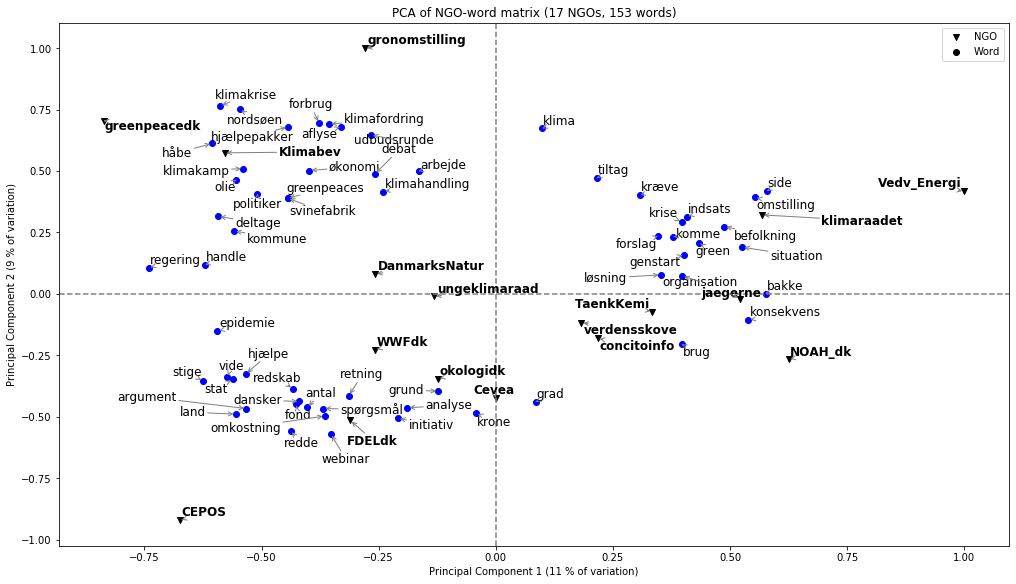

In [20]:
### Plot the socio-symbolic constellation
from adjustText import adjust_text
fig, ax = plt.subplots(1,1, figsize = (14,8), constrained_layout=True)

# Title and label text 
ax.set_title('PCA of NGO-word matrix ({} NGOs, {} words)'.format(standardized_actor2type_frequency.shape[0],
                                                                 standardized_actor2type_frequency.shape[1],
                                                                 fontsize = 20,fontweight='bold'))
ax.set_xlabel('Principal Component 1 ({:0.0f} % of variation)'.format(100*pca.explained_variance_ratio_[0], fontsize = 15))
ax.set_ylabel('Principal Component 2 ({:0.0f} % of variation)'.format(100*pca.explained_variance_ratio_[1], fontsize = 15))

# Grid to mark zero loading             
ax.axvline(x=0, c='grey', linestyle='--')
ax.axhline(y=0, c='grey', linestyle='--')
       
# Plot standardized principal component scores
ax.scatter(scaled_PC[:,0], scaled_PC[:,1], marker = 'v', label='NGO', c='black')

# Plot word loadings
ax.scatter(PC_plot_load[:,0], PC_plot_load[:, 1], marker = 'o', label='Word', c='blue')

# Annotate the plot
texts = []
for x, y, txt in zip(scaled_PC[:,0], scaled_PC[:,1], actor_names):
    texts.append(plt.text(x, y, txt, size=12, weight='bold'))


for x, y, txt in zip(PC_plot_load[:,0], PC_plot_load[:,1], PC_plot_names):
    texts.append(plt.text(x, y, txt, size=12))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey')) # This part is slow

# Set legend to black
plt.legend()
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')
             
plt.show()

# Examples in lecture
* Run at least section 1+2 above, before this

## PCA  and dimensionality reduction

In [21]:
# Select words
words = ['klimakrise', 'nordsøen'] 

# Get their indices
count_widx = [vectorizer.vocabulary_[w] for w in words]
standardized_widx = [np.where(type_names[assoc_idx]==w)[0][0] for w in words]

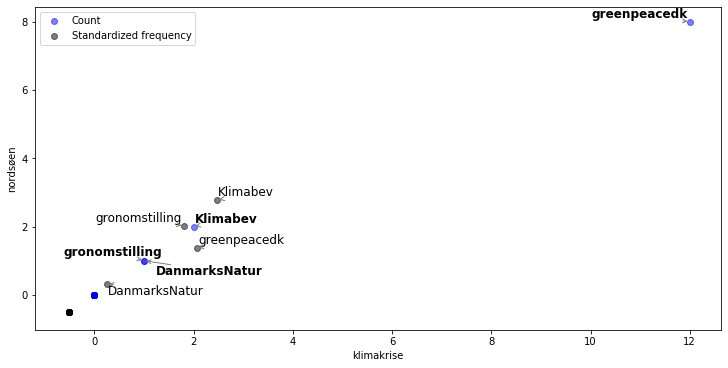

In [22]:
### Plot count and frequency
fig, ax = plt.subplots(1,1, figsize = (10,5), constrained_layout=True)

ax.set_xlabel(words[0])
ax.set_ylabel(words[1])
ax.scatter(actor2type[:,count_widx[0]], actor2type[:,count_widx[1]],
           alpha=0.5, label='Count', color='blue')
ax.scatter(standardized_actor2type_frequency[:,standardized_widx[0]],
           standardized_actor2type_frequency[:,standardized_widx[1]],
           alpha=0.5,label='Standardized frequency', color='black')

texts = []

for x, y, txt in zip(actor2type[:,count_widx[0]], actor2type[:,count_widx[1]], actor_names):
    if (x!=0) and (y!=0):
        texts.append(plt.text(x, y, txt, size=12, weight='bold'))
for x, y, txt in zip(standardized_actor2type_frequency[:,standardized_widx[0]],
                     standardized_actor2type_frequency[:,standardized_widx[1]],
                     actor_names):
    if (x>0) and (y>0):
        texts.append(plt.text(x, y, txt, size=12))
    
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey')) # This part is slow
plt.legend()
plt.show()

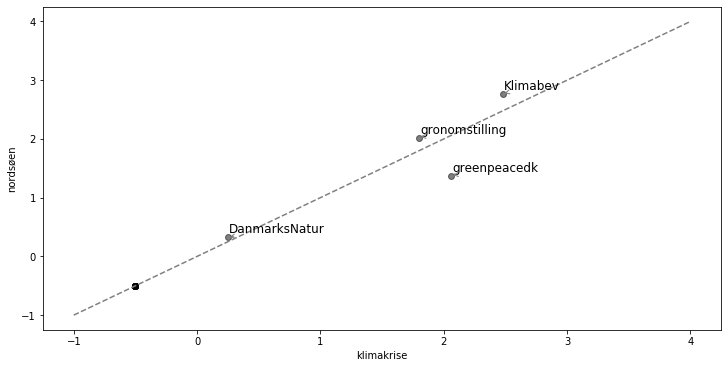

In [23]:
### Plot count, frequency and line
fig, ax = plt.subplots(1,1, figsize = (10,5), constrained_layout=True)

ax.set_xlabel(words[0])
ax.set_ylabel(words[1])
ax.scatter(standardized_actor2type_frequency[:,standardized_widx[0]],
           standardized_actor2type_frequency[:,standardized_widx[1]],
           alpha=0.5,label='Standardized frequency', color='black')

ax.plot([-1,4], [-1,4], ls='--', color='grey')        

texts = []
for x, y, txt in zip(standardized_actor2type_frequency[:,standardized_widx[0]],
                     standardized_actor2type_frequency[:,standardized_widx[1]],
                     actor_names):
    if (x>0) and (y>0):
        texts.append(plt.text(x, y, txt, size=12))
        
    
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey')) # This part is slow
plt.show()

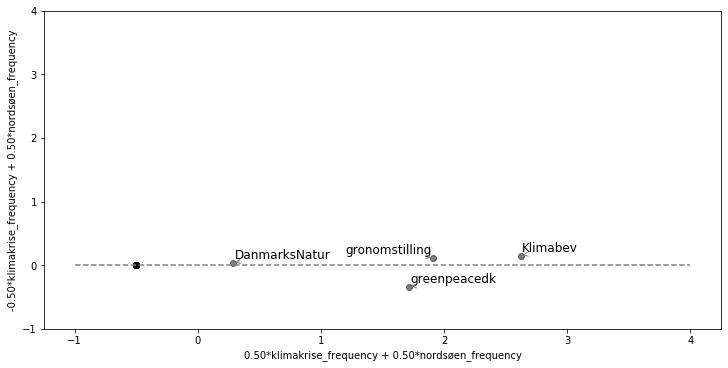

In [24]:
### Plot count, frequency and line
fig, ax = plt.subplots(1,1, figsize = (10,5), constrained_layout=True)

rot_arr = np.array([[0.5,-0.5], [0.5,0.5]])
rotation = standardized_actor2type_frequency[:,standardized_widx]@rot_arr

ax.set_xlabel('{:0.2f}*'.format(rot_arr[0,0])+words[0]+'_frequency + {:0.2f}*'.format(rot_arr[1,0])+words[1]+'_frequency')
ax.set_ylabel('{:0.2f}*'.format(rot_arr[0,1])+words[0]+'_frequency + {:0.2f}*'.format(rot_arr[1,1])+words[1]+'_frequency')
ax.scatter(rotation[:,0], rotation[:,1], alpha=0.5,label='Standardized frequency', color='black')

ax.plot([-1,4], [0,0], ls='--', color='grey')
ax.set_ylim(-1,4)

texts = []
for x, y, txt in zip(rotation[:,0], rotation[:,1], actor_names):
    if (x>0):
        texts.append(plt.text(x, y, txt, size=12))
        
    
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey')) # This part is slow
plt.show()

In [25]:
# Perform SVD
U, s, VT = np.linalg.svd(standardized_actor2type_frequency[:,standardized_widx], full_matrices=False)
S = np.diag(s)
PC = U*np.sqrt(n_actors-1) 
L = VT.T@S/np.sqrt(n_actors-1)
W = (VT.T@np.linalg.inv(S))*np.sqrt(n_actors-1)
eigen_values = np.diag(S@S)/(S.shape[0]-1)
explained_variance = eigen_values / np.sum(eigen_values)

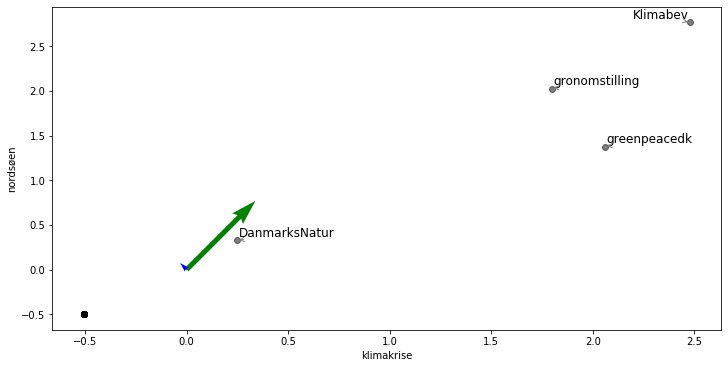

In [26]:
### Plot count, frequency and principal directions
fig, ax = plt.subplots(1,1, figsize = (10,5), constrained_layout=True)

ax.set_xlabel(words[0])
ax.set_ylabel(words[1])
ax.scatter(standardized_actor2type_frequency[:,standardized_widx[0]],
           standardized_actor2type_frequency[:,standardized_widx[1]],
           alpha=0.5, label='Standardized frequency', color='black')

texts = []
for x, y, txt in zip(standardized_actor2type_frequency[:,standardized_widx[0]],
                     standardized_actor2type_frequency[:,standardized_widx[1]],
                     actor_names):
    if (x>0) and (y>0):
        texts.append(plt.text(x, y, txt, size=12))
    
# Plot principal directions
origin = np.array([[0, 0],[0, 0]]) # origin point
ax.quiver(*origin, L[0,:], L[1,:], color=['g','b'], scale=10)

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey')) # This part is slow
plt.show()

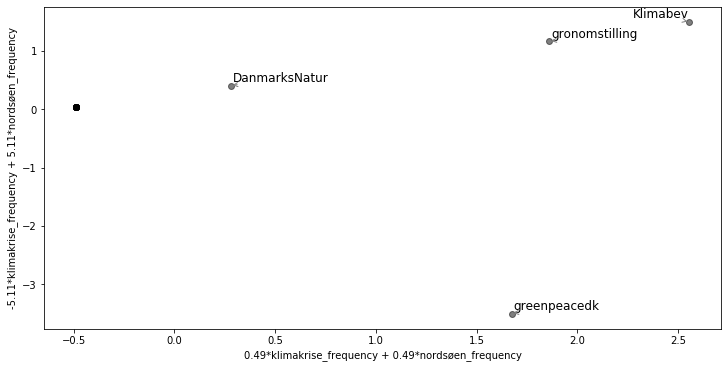

In [27]:
### Plot count, frequency and line
fig, ax = plt.subplots(1,1, figsize = (10,5), constrained_layout=True)

PC = standardized_actor2type_frequency[:,standardized_widx]@W

ax.set_xlabel('{:0.2f}*'.format(W[0,0])+words[0]+'_frequency + {:0.2f}*'.format(W[1,0])+words[1]+'_frequency')
ax.set_ylabel('{:0.2f}*'.format(W[0,1])+words[0]+'_frequency + {:0.2f}*'.format(W[1,1])+words[1]+'_frequency')
ax.scatter(PC[:,0], PC[:,1], alpha=0.5, color='black')

texts = []
for x, y, txt in zip(PC[:,0], PC[:,1], actor_names):
    if (x>0):
        texts.append(plt.text(x, y, txt, size=12))
        
    
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey')) # This part is slow
plt.show()

In [28]:
# Calculate the cumulative amount of variance captured 
cumulative_variance = np.cumsum(explained_variance)

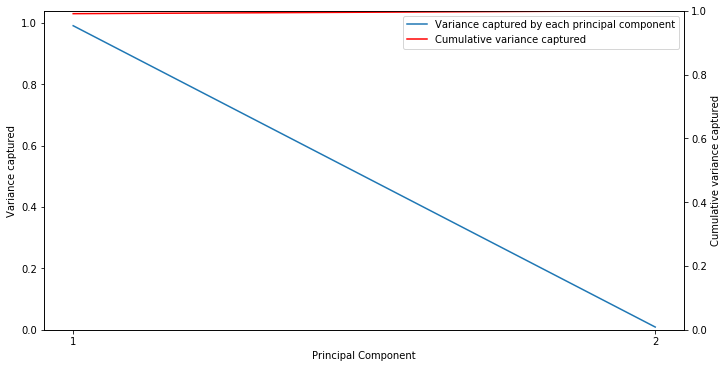

In [29]:
### Assess the amount of variance captured by each principal components
fig, ax = plt.subplots(1,1, figsize = (10,5), constrained_layout=True)

# Plot the amount of variance captured by each principal components
sc1 = ax.plot(range(1, L.shape[1]+1), explained_variance, label='Variance captured by each principal component')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance captured')
ax.set_ylim(ymin=0)
ax.set_xticks(range(1, L.shape[1]+1))

# Plot the cumulative amount of variance captured on second y-axis
ax2 = ax.twinx()  # Create second y-axis
sc2 = ax2.plot(range(1, L.shape[1]+1), cumulative_variance, color='red', label='Cumulative variance captured')
ax2.set_ylabel('Cumulative variance captured')
ax2.set_ylim(ymin=0)
ax2.set_xticks(range(1, L.shape[1]+1))

plt.legend(handles = [sc1[0], sc2[0]], loc=1)
plt.show()

In [30]:
### Inspect the loadings, i.e. correlation between standardized word frequencies and standardized PCs
# absolute value > 1 likely due to SVD solver procedure
pd.DataFrame(L, index=words, columns=['PC{}'.format(d) for d in range(1,L.shape[1]+1)])

,PC1,PC2
klimakrise,1.026122,-0.097849
nordsøen,1.026122,0.097849


In [31]:
### Inspect the weights of each word for each PC - plotted on the axis labels above 
pd.DataFrame(W, index=words, columns=['PC{}'.format(d) for d in range(1,L.shape[1]+1)])

,PC1,PC2
klimakrise,0.487272,-5.109899
nordsøen,0.487272,5.109899


## PCA and ranking of dimensions

In [32]:
# Select words
words = ['klimakrise', 'nordsøen', 'stat', 'omkostning'] 

# Get their indices
count_widx = [vectorizer.vocabulary_[w] for w in words]
standardized_widx = [np.where(type_names[assoc_idx]==w)[0][0] for w in words]

In [33]:
# Perform SVD
U, s, VT = np.linalg.svd(standardized_actor2type_frequency[:,standardized_widx], full_matrices=False)
S = np.diag(s)
PC = U*np.sqrt(n_actors-1) # Columns of PC are the standardized scores
L = VT.T@S/np.sqrt(n_actors-1) # Only unique up to a factor, so sign (direction) may change compared to other implementations
W = (VT.T@np.linalg.inv(S))*np.sqrt(n_actors-1)
eigen_values = np.diag(S@S)/(S.shape[0]-1) # Of correlation matrix
explained_variance = eigen_values / np.sum(eigen_values)

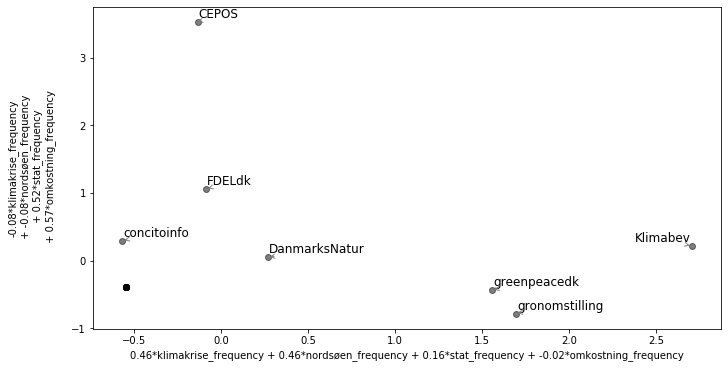

In [34]:
### Plot count, frequency and line
fig, ax = plt.subplots(1,1, figsize = (10,5), constrained_layout=True)

PC = standardized_actor2type_frequency[:,standardized_widx]@W

ax.set_xlabel(' + '.join(['{:0.2f}*{}_frequency'.format(weight, word) for word, weight in zip(words, W[:,0])]))
ax.set_ylabel(' + '.join(['{:0.2f}*{}_frequency\n'.format(weight, word) for word, weight in zip(words, W[:,1])]))
ax.scatter(PC[:,0], PC[:,1], alpha=0.5, color='black')

texts = []
for x, y, txt in zip(PC[:,0], PC[:,1], actor_names):
    if (x>0) or (y>0):
        texts.append(plt.text(x, y, txt, size=12))
        
    
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey')) # This part is slow
plt.show()

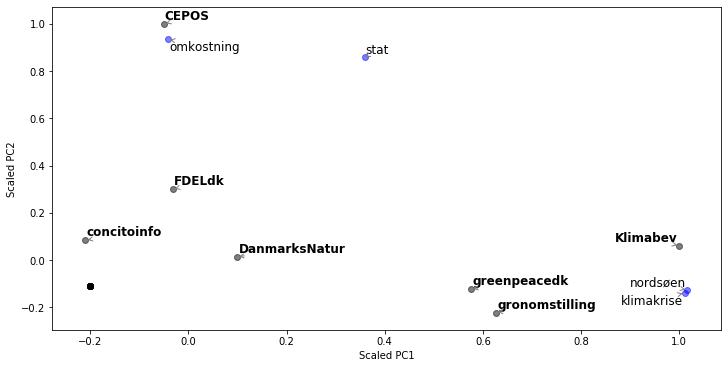

In [35]:
### Plot count, frequency and line
fig, ax = plt.subplots(1,1, figsize = (10,5), constrained_layout=True)

scaled_PC = PC / np.max(abs(PC), axis=0)

ax.set_xlabel('Scaled PC1')
ax.set_ylabel('Scaled PC2')
ax.scatter(scaled_PC[:,0], scaled_PC[:,1], alpha=0.5, color='black')
ax.scatter(L[:,0], L[:,1], alpha=0.5, color='blue')


texts = []
for x, y, txt in zip(scaled_PC[:,0], scaled_PC[:,1], actor_names):
    if (x>0) or (y>0):
        texts.append(plt.text(x, y, txt, size=12, weight='bold'))
for x, y, txt in zip(L[:,0], L[:,1], words):
    if (x>0) or (y>0):
        texts.append(plt.text(x, y, txt, size=12))
        
    
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey')) # This part is slow
plt.show()

In [36]:
# Calculate the cumulative amount of variance captured 
cumulative_variance = np.cumsum(explained_variance)

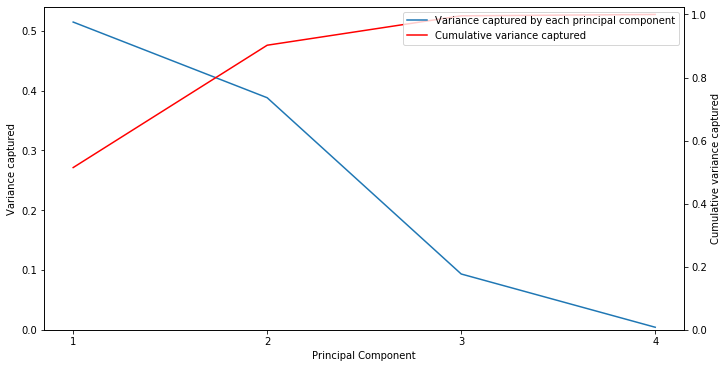

In [37]:
### Assess the amount of variance captured by each principal components
fig, ax = plt.subplots(1,1, figsize = (10,5), constrained_layout=True)

# Plot the amount of variance captured by each principal components
sc1 = ax.plot(range(1, L.shape[1]+1), explained_variance, label='Variance captured by each principal component')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance captured')
ax.set_ylim(ymin=0)
ax.set_xticks(range(1, L.shape[1]+1))

# Plot the cumulative amount of variance captured on second y-axis
ax2 = ax.twinx()  # Create second y-axis
sc2 = ax2.plot(range(1, L.shape[1]+1), cumulative_variance, color='red', label='Cumulative variance captured')
ax2.set_ylabel('Cumulative variance captured')
ax2.set_ylim(ymin=0)
ax2.set_xticks(range(1, L.shape[1]+1))

plt.legend(handles = [sc1[0], sc2[0]], loc=1)
plt.show()

In [38]:
### To understand this plot, let's compare the variance of each word with the variance captures by each dimension 

## The total variance to capture is the sum of each words variance
total_variance = standardized_actor2type_frequency[:,standardized_widx].T@standardized_actor2type_frequency[:,standardized_widx]/n_actors
print(total_variance) # The correlation matrix (given unit scale input, otherwise covariance matrix)
print(np.diag(total_variance)) # The variance of each variable (equal to one given unit scale)
print(sum(np.diag(total_variance))) # The sum of each words variance - given correlation, just equal to the number of words
# This sum is the total variance to be captured or 'explained'

## The eigen values (squared singular values) show how much of the total variance, that each principal dimension captures
# Whereas each word captures 1/#words share of the variance, this is much more concentrated for the principal components!
print(np.diag(S**2/n_actors))
print(sum(np.diag(S**2/n_actors))) # Collectively, the principal components capture the total variance

## The plot above shows the share of total variance explained for each principal components
## i.e. it scales the array of eigenvalues
print(np.diag(S**2/n_actors)/sum(np.diag(S**2/n_actors)))

[[ 1.          0.98197744  0.18501093 -0.11826895]
 [ 0.98197744  1.          0.21410774 -0.12536054]
 [ 0.18501093  0.21410774  1.          0.56336587]
 [-0.11826895 -0.12536054  0.56336587  1.        ]]
[1. 1. 1. 1.]
3.999999999999999
[2.05791641 1.55187096 0.37316976 0.01704287]
4.000000000000002
[0.5144791  0.38796774 0.09329244 0.00426072]


In [39]:
# Inspect correlations
# absolute value > 1 might be due to dividing by N-1 (i.e. we view the tweets as a sample and estimate the mean)
# as opposed to dividing by N (we view the tweets as the full population, so no estimation)
pd.DataFrame(L, index=words, columns=['PC{}'.format(d) for d in range(1,L.shape[1]+1)])

,PC1,PC2,PC3,PC4
klimakrise,1.010999,-0.139496,0.109741,-0.094231
nordsøen,1.016283,-0.127529,0.064975,0.095829
stat,0.360361,0.858895,-0.441485,-0.005426
omkostning,-0.041550,0.935649,0.430487,0.003993


In [40]:
# Inspect weights, i.e. how much each word contribute to each PC
pd.DataFrame(W, index=words, columns=['PC{}'.format(d) for d in range(1,L.shape[1]+1)])

,PC1,PC2,PC3,PC4
klimakrise,0.462374,-0.084602,0.276780,-5.203836
nordsøen,0.464791,-0.077344,0.163874,5.292044
stat,0.164809,0.520902,-1.113476,-0.299648
omkostning,-0.019003,0.567451,1.085736,0.220531
